In [86]:
import pulp
from pulp import LpVariable as Var
from pulp import lpSum
import pandas as pd
import matplotlib.pyplot as plt

In [87]:
### Data for question 3b

n = [0.15,0.30]
m = [0.0,0.0]
l = [3,5]
s = [1.5,2.5]
p = [1,1]

def min_cost_battery_flow_demo(n, m, l, s, p):
    """
    Optimal charge and discharge of a residential battery 
    which minimises the cost for the consumer.

    n: import price ($/kWh)
    m: export price ($/kWh)
    l: load (kW) at interval t
    s: solar export (kW) at interval t
    p: binary variable - is the ev connected (1) at interval t
    """

    lp = pulp.LpProblem()

    ## variables

    # physical variables
    battery_charge = [Var(f"B_{t}",lowBound=0,upBound=15) for t in range(len(n))]
    ev_charge = [Var(f"EV_{t}",lowBound=0,upBound=60) for t in range(len(n))]

    # decision variables
    b = [Var(f"b_{t}",lowBound=-5,upBound=5) for t in range(len(n))] # discharging is positive
    c = [Var(f"c_{t}",lowBound=0,upBound=7.5) for t in range(len(n))] # charging is positive
    g_i = [Var(f"g_i_{t}",lowBound=0) for t in range(len(n))] # import from grid at t
    g_e = [Var(f"g_e_{t}",lowBound=0) for t in range(len(n))] # export from grid at t

    ## constraints

    # initial charge values
    lp += battery_charge[0] == 5
    lp += ev_charge[0] == 20

    # flow preservation
    for t in range(len(n)):

        # flow at the meter 
        lp += g_i[t] - g_e[t] + s[t] + b[t] == l[t] + p[t]*c[t]

        # state of battery charge at t+1 timestep is the charge at t
        # summed with the power flowing to or from the battery at t
        if t<len(n)-1:
            lp += battery_charge[t] - b[t] == battery_charge[t+1]
            lp += ev_charge[t] + p[t]*c[t] == ev_charge[t+1]

    # final charge values
    lp += ev_charge[-1]+c[-1] == 29
    lp += battery_charge[-1]-b[-1] >= 0

    ## objective - minimise consumer cost
    lp += lpSum(g_i[t]*n[t] - g_e[t]*m[t] for t in range(len(n)))

    lp.solve()

    print(f'Status: {pulp.LpStatus[lp.status]}')
    print(f'Objective: {lp.objective.value()}')
    print('Optimal values:')
    print("B: ",[B_t.value() for B_t in battery_charge])
    print("EV: ",[EV_t.value() for EV_t in ev_charge])
    print("Battery Charge/Discharge rate: ",[b_t.value() for b_t in b])
    print("EV Charge Rate: ",[c_t.value() for c_t in c])
    print("Grid Import Flow: ",[g_t.value() for g_t in g_i])
    print("Grid Export Flow: ",[g_t.value() for g_t in g_e])
    print("NET Grid Flow: ",[i.value() - e.value() for i,e in zip(g_i,g_e)])


min_cost_battery_flow_demo(n,m,l,s,p)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/42/f9_c0v657j907h_6gh8ly4mw0000gn/T/3d2da06132a84aef9e79f6d447cb7d68-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/42/f9_c0v657j907h_6gh8ly4mw0000gn/T/3d2da06132a84aef9e79f6d447cb7d68-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 36 RHS
At line 45 BOUNDS
At line 56 ENDATA
Problem MODEL has 8 rows, 12 columns and 20 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (-5) rows, 5 (-7) columns and 8 (-12) elements
0  Obj 0 Primal inf 14.999999 (1)
4  Obj 1.2
Optimal - objective value 1.2
After Postsolve, objective 1.2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 1.2 - 4 iterations time 0.002, Presolve 0.00
Option for printin

In [88]:
### Data for question 4b

df = pd.read_csv("household_data.csv")

df


,Hour,Load (kW),Solar Generation (kW),Cost of energy Import ($/kWh),Value of energy export ($/kWh),Car plugged p(t),Car consumption (kWh),Emissions (gCO2e/kWh)
0,1,0.40,0.00,0.2,0.08,1,0,741.050
1,2,1.92,0.00,0.2,0.08,1,0,745.535
2,3,0.63,0.00,0.2,0.08,1,0,751.775
3,4,1.41,0.00,0.2,0.08,1,0,756.105
4,5,1.68,0.00,0.2,0.08,1,0,752.685
5,6,1.08,0.00,0.2,0.08,1,0,743.070
6,7,4.53,0.00,0.4,0.08,0,4,714.360
7,8,7.61,0.07,0.4,0.08,0,0,647.505
8,9,3.91,1.23,0.4,0.08,0,0,546.475
9,10,0.98,4.84,0.3,0.08,0,0,472.020


In [89]:
colors = ["#FF0200","#00A18A","#F2AC00","#FA8501","#5CBCD6","#5B1A19","#FF6567"]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/42/f9_c0v657j907h_6gh8ly4mw0000gn/T/f13576e169254267a9a4dc8af9dc4472-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/42/f9_c0v657j907h_6gh8ly4mw0000gn/T/f13576e169254267a9a4dc8af9dc4472-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 98 COLUMNS
At line 384 RHS
At line 478 BOUNDS
At line 588 ENDATA
Problem MODEL has 93 rows, 133 columns and 237 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 47 (-46) rows, 101 (-32) columns and 156 (-81) elements
Perturbing problem by 0.001% of 0.4 - largest nonzero change 1.0090687e-06 ( 0.0012613359%) - largest zero change 1.0045297e-06
0  Obj 5.0264204 Primal inf 251.10995 (46) Dual inf 2.1599597 (23)
0  Obj 5.0264 Primal in

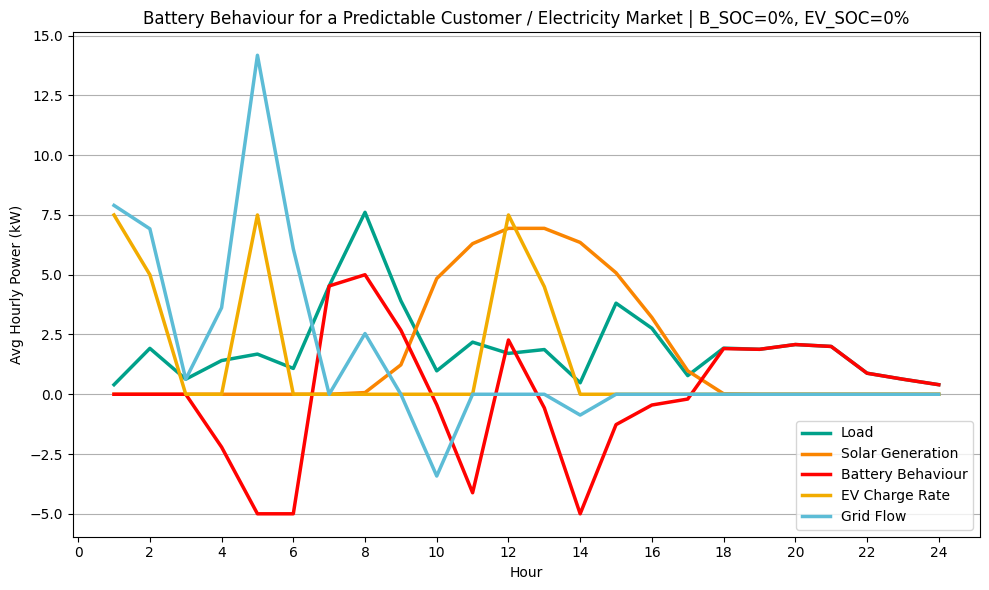

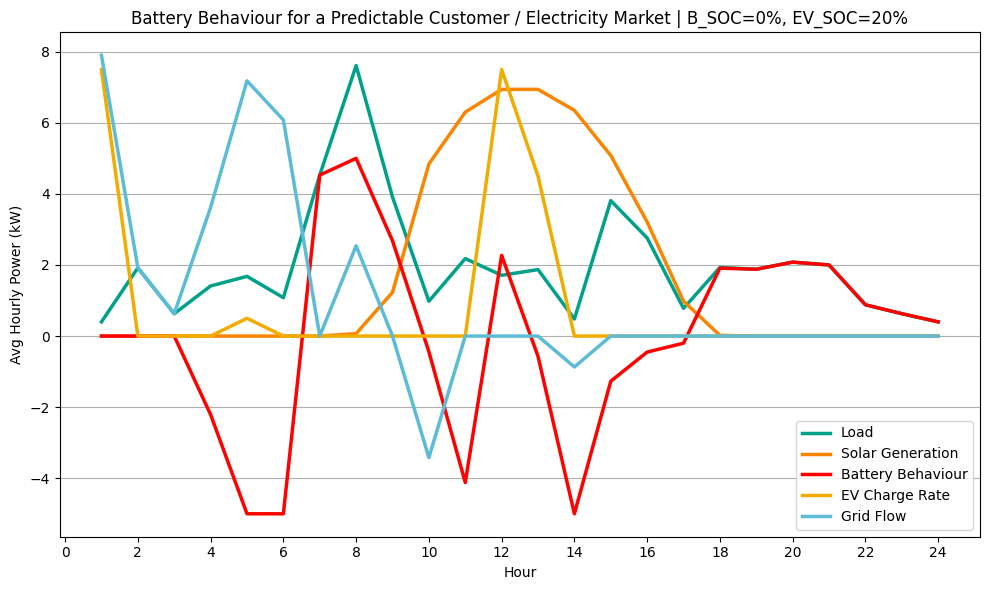

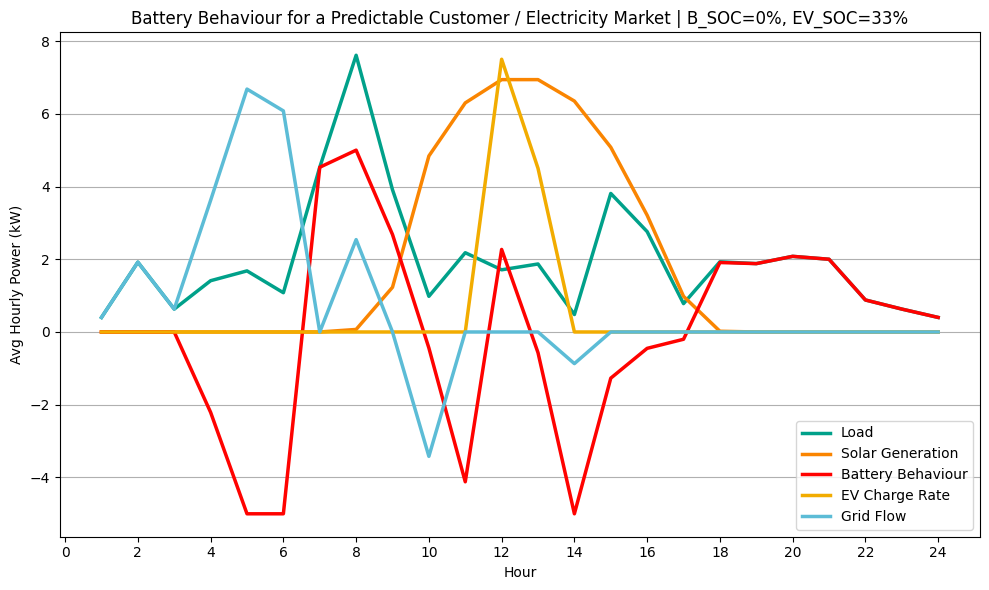

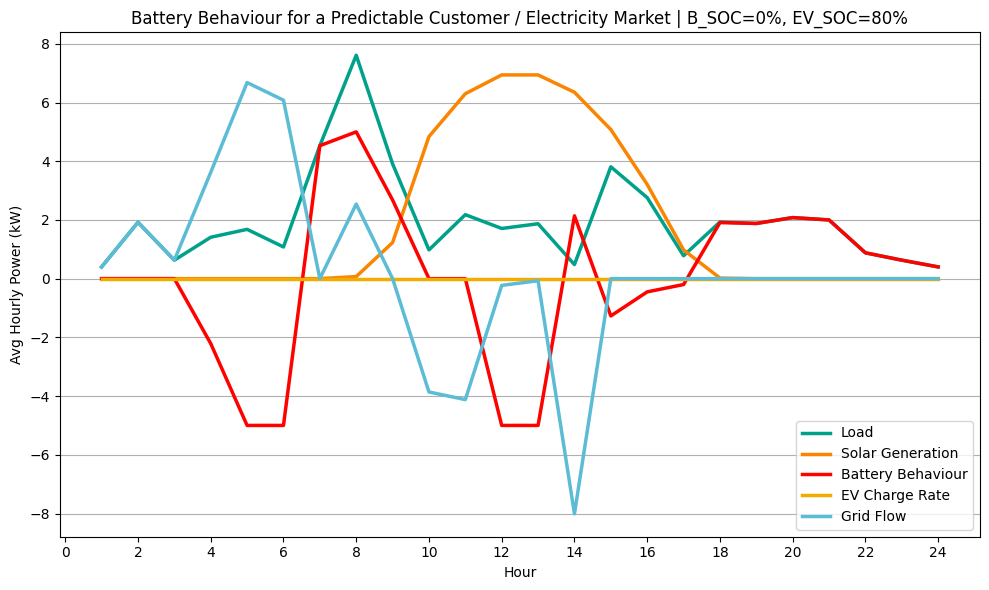

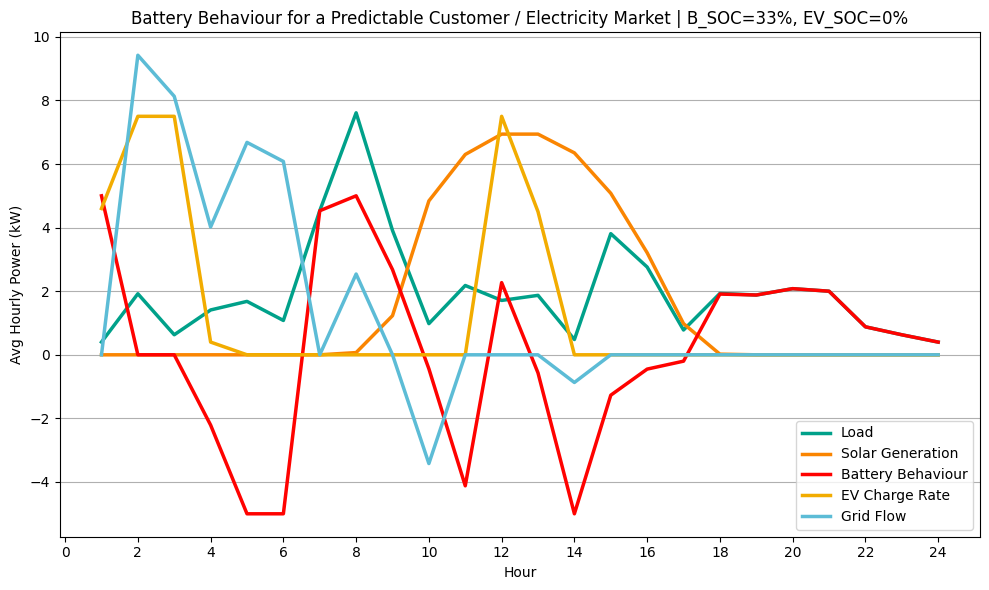

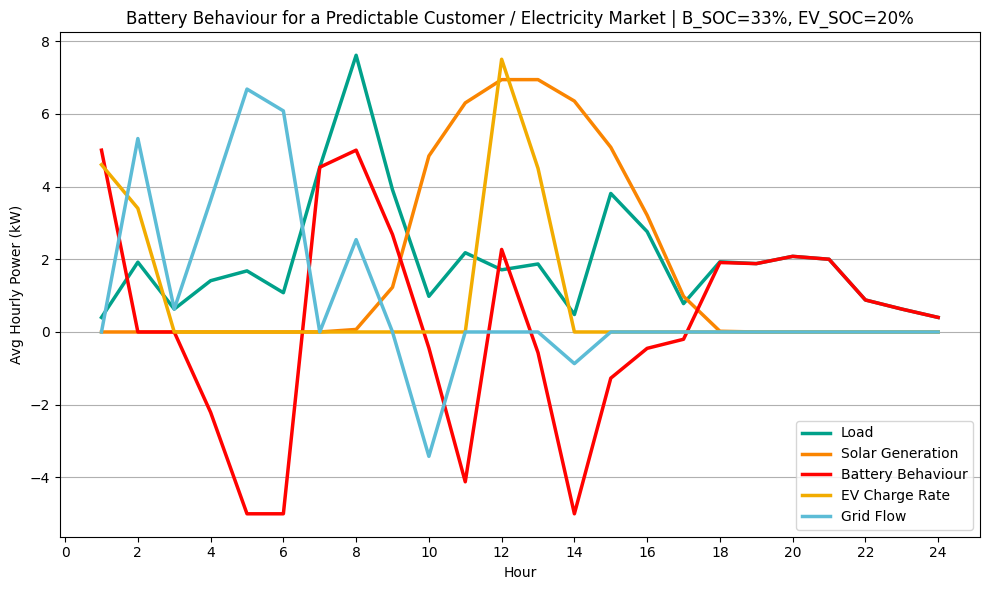

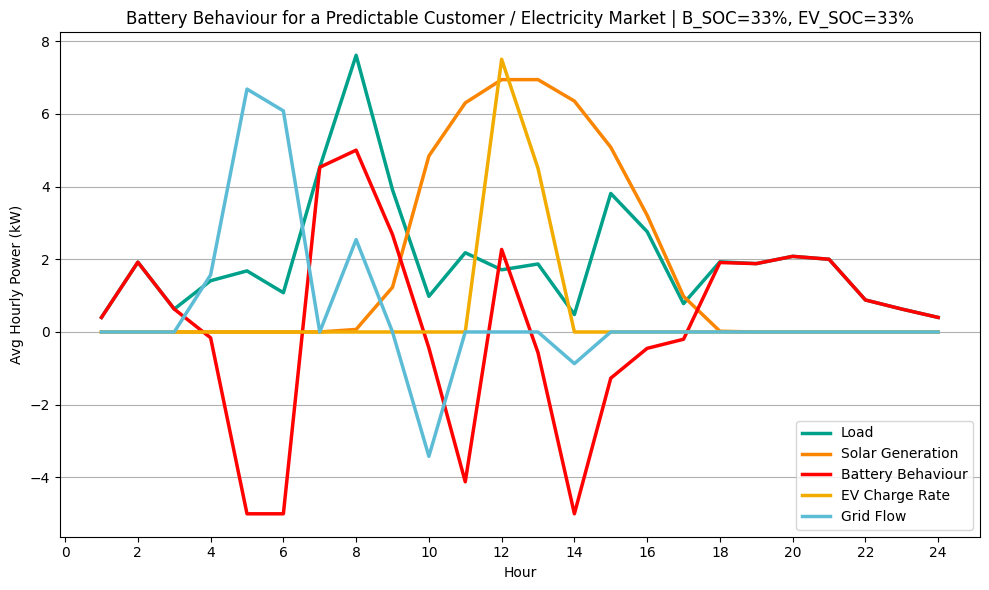

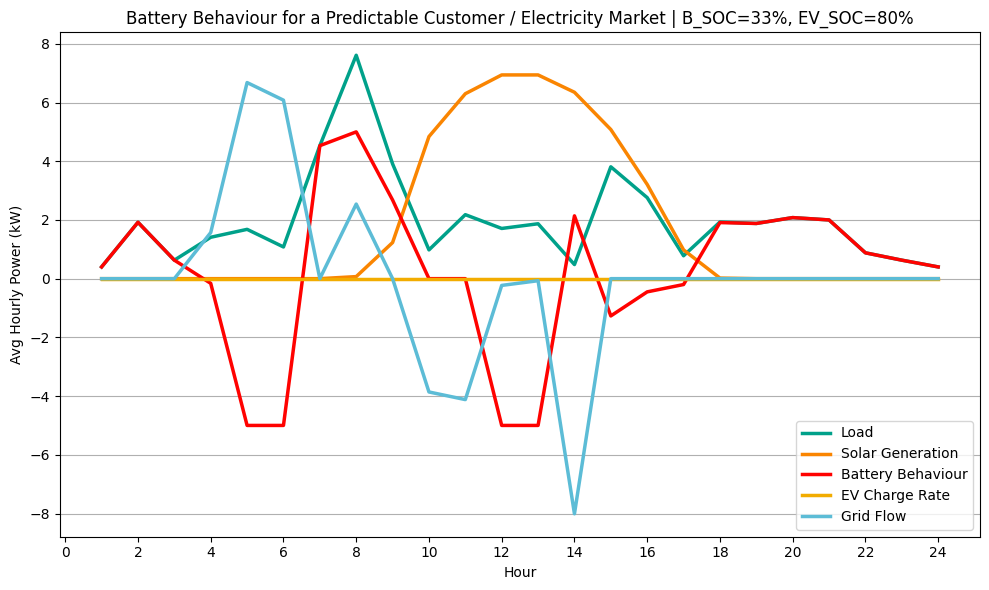

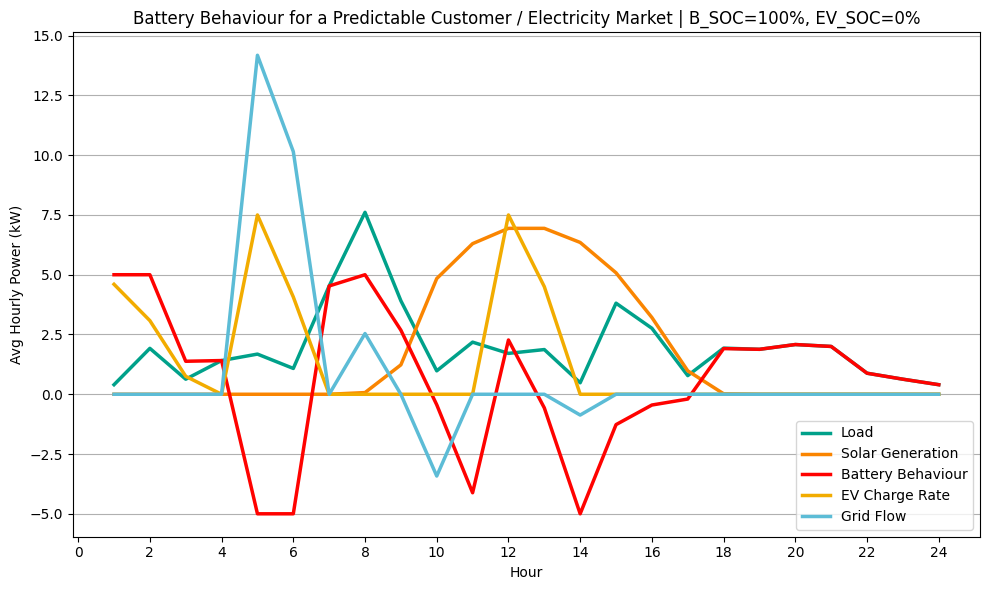

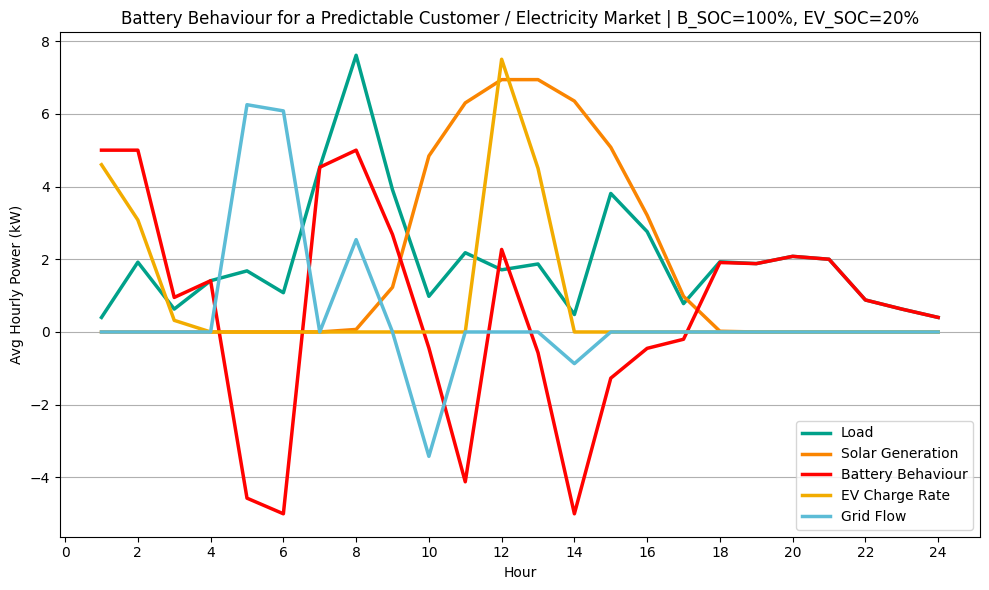

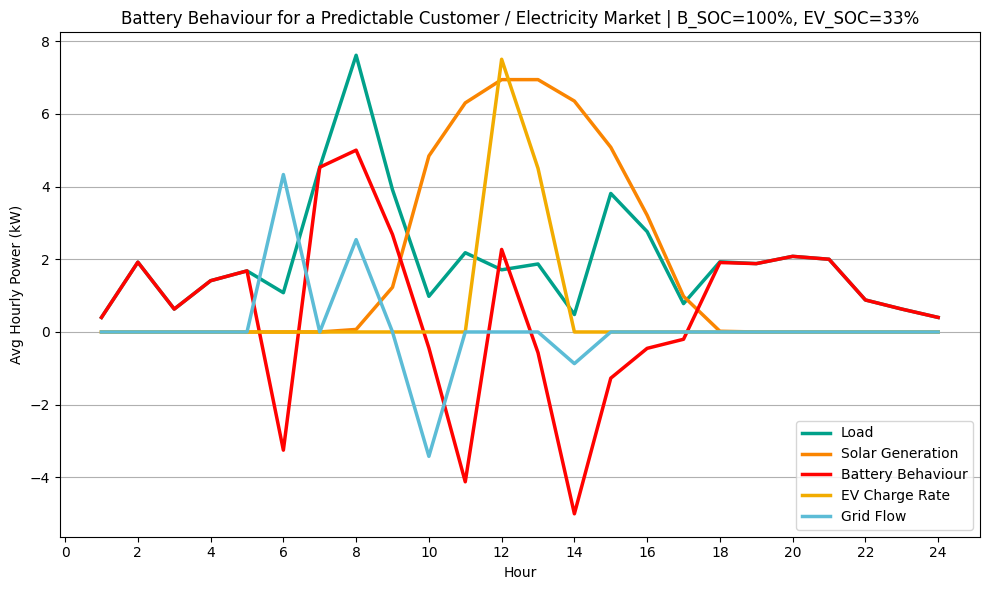

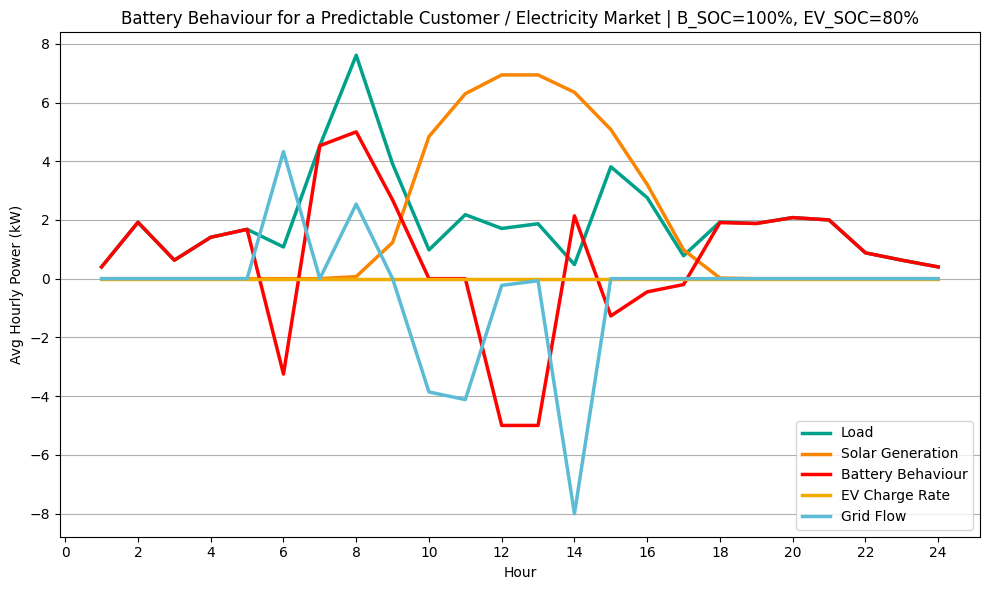

In [124]:
### Data for question 4b

df = pd.read_csv("household_data.csv")

n = df["Cost of energy Import ($/kWh)"].to_list()
m = df["Value of energy export ($/kWh)"].to_list()
l = df["Load (kW)"].to_list()
s = df["Solar Generation (kW)"].to_list()
p = df["Car plugged p(t)"].to_list()
u = df["Car consumption (kWh)"].to_list()


def min_cost_battery_flow_day(n, m, l, s, p, u,B_C,B_SOC,EV_C,EV_SOC):
    """
    Finds the optimal charge and discharge behaviour of a 
    residential battery which minimises the cost for the consumer.

    The following variables are defined for every interval t:

    n: import price ($/kWh)
    m: export price ($/kWh)
    l: load (kW)
    s: solar export (kW)
    p: binary variable - is the EV connected (1) or disconnected (0)
    u: how much energy the EV uses (kWh)

    where the interval lasts from t=0h to t=24h
    """

    lp = pulp.LpProblem()

    ## variables

    # physical variables
    battery_charge = [Var(f"B_{t}",lowBound=0,upBound=15) for t in range(len(n))]
    ev_charge = [Var(f"EV_{t}",lowBound=0,upBound=60) for t in range(len(n))]

    # decision variables
    b = [Var(f"b_{t}",lowBound=-5,upBound=5) for t in range(len(n))] # discharging is positive
    c = [Var(f"c_{t}",lowBound=0,upBound=7.5) for t in range(len(n))] # charging is positive
    g_i = [Var(f"g_i_{t}",lowBound=0) for t in range(len(n))] # import from grid at t
    g_e = [Var(f"g_e_{t}",lowBound=0) for t in range(len(n))] # export from grid at t

    ## constraints

    # start of the day charge values (midnight)
    lp += battery_charge[0] == B_C
    lp += ev_charge[0] == EV_C

    # flow preservation
    for t in range(len(n)):

        # flow at the meter 
        lp += g_i[t] - g_e[t] + s[t] + b[t] == l[t] + p[t]*c[t]

        # state of battery charge at t+1 timestep is the charge at t
        # summed with the power flowing to or from the battery at t
        if t<len(n)-1:
            lp += battery_charge[t] - b[t] == battery_charge[t+1]
            lp += ev_charge[t] + p[t]*c[t] - u[t] == ev_charge[t+1]
        
        # ev should have enough charge at the start of the day 
        # impose rule that ev is charged to 20% SOC at the start of 7 am
        if EV_C == 0:
            if t>= 5:
                lp+=ev_charge[t] >= 12
        else:
            lp+=ev_charge[t] >= 12

    # end of the day charge values (midnight)
    lp += ev_charge[-1]+c[-1] >= 12
    lp += battery_charge[-1]-b[-1] >= 0

    

    ## objective - minimise consumer cost
    lp += lpSum(g_i[t]*n[t] - g_e[t]*m[t] for t in range(len(n)))

    lp.solve()

    print(f'Status: {pulp.LpStatus[lp.status]}')
    print(f'Objective: {lp.objective.value()}')
    print('Optimal values:')
    print("B: ",[B_t.value() for B_t in battery_charge])
    print("EV: ",[EV_t.value() for EV_t in ev_charge])
    print("Battery Charge/Discharge rate: ",[b_t.value() for b_t in b])
    print("EV Charge Rate: ",[c_t.value() for c_t in c])
    print("Grid Import Flow: ",[g_t.value() for g_t in g_i])
    print("Grid Export Flow: ",[g_t.value() for g_t in g_e])
    print("NET Grid Flow: ",[i.value() - e.value() for i,e in zip(g_i,g_e)])
    
    t = df["Hour"].to_list()

    plt.rcParams['lines.linewidth'] = 2.5
    plt.figure(figsize=(10,6))
    plt.grid(axis='y')

    plt.plot(t,l,label="Load",color=colors[1])
    plt.plot(t,s,label="Solar Generation",color=colors[3])
    plt.plot(t,[b_t.value() for b_t in b],label="Battery Behaviour",color=colors[0])
    plt.plot(t,[c_t.value() if c_t else 0 for c_t in c],label="EV Charge Rate",color=colors[2])
    plt.plot(t,[i.value() - e.value() for i,e in zip(g_i,g_e)],label="Grid Flow",color=colors[4])

    plt.title(f"Battery Behaviour for a Predictable Customer / Electricity Market | B_SOC={B_SOC}%, EV_SOC={EV_SOC}%")
    plt.ylabel("Avg Hourly Power (kW)")
    plt.xlabel("Hour")
    plt.legend(loc="lower right")
    # plt.show()
    plt.xticks(ticks=[i for i in range(0,25,2)],labels=["0","2","4","6","8","10","12","14","16","18","20","22","24"])
    plt.tight_layout()
    plt.savefig(f"MinCost/cost_optimal_b{B_C}_ev{EV_C}.png",dpi=200)

    return round(lp.objective.value(),2)

cost_data = {0:[],
             5:[],
             15:[]}

for bc, bsoc in [(0,0),(5,33),(15,100)]:
    for evc,evsoc in [(0,0),(12,20),(20,33),(48,80)]:

        cost_data[bc].append(min_cost_battery_flow_day(n,m,l,s,p,u,B_C=bc,B_SOC=bsoc,EV_C=evc,EV_SOC=evsoc))


In [125]:
print(cost_data)

{0: [8.54, 6.14, 4.54, 3.58], 5: [7.54, 5.14, 3.54, 2.58], 15: [5.54, 3.14, 1.54, 0.58]}


Q4 

Part C

The battery behaviour makes sense. It is charging up just before a large load (predictable customer) and then discharges during the peak load times. When there is excess solar the battery charges up just enough so that it can last the night, but not too much so that it can export and make some money back.

Part D

Obviously, it is not realistic for the customer to have a predictable load every single day, and it will be wildly inaccurate and irresponsible to optimise for the customer over one day, as it does not account for bigger picture optimisations (load profiles differ on the weekends for example). In addition, the time intervals are far too large. The National Electricity Market operates in 5 minute intervals, so the battery should optimise accordingly, i.e. in line with the 5 minute settlements.

# Q5 Decarbonisation

In [ ]:
df = pd.read_csv("household_data.csv")
df

# A rolling average was taken since emissions is an intensive property
# df.rolling(2).mean()[1::2]["Emissions (gCO2e/kWh)"].to_csv("yo.csv")

,Hour,Load (kW),Solar Generation (kW),Cost of energy Import ($/kWh),Value of energy export ($/kWh),Car plugged p(t),Car consumption (kWh),Emissions (gCO2e/kWh)
0,1,0.40,0.00,0.2,0.08,1,0,741.050
1,2,1.92,0.00,0.2,0.08,1,0,745.535
2,3,0.63,0.00,0.2,0.08,1,0,751.775
3,4,1.41,0.00,0.2,0.08,1,0,756.105
4,5,1.68,0.00,0.2,0.08,1,0,752.685
5,6,1.08,0.00,0.2,0.08,1,0,743.070
6,7,4.53,0.00,0.4,0.08,0,4,714.360
7,8,7.61,0.07,0.4,0.08,0,0,647.505
8,9,3.91,1.23,0.4,0.08,0,0,546.475
9,10,0.98,4.84,0.3,0.08,0,0,472.020


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/42/f9_c0v657j907h_6gh8ly4mw0000gn/T/0495b45ee26f4c388ff8f5ef64b9d564-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/42/f9_c0v657j907h_6gh8ly4mw0000gn/T/0495b45ee26f4c388ff8f5ef64b9d564-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 98 COLUMNS
At line 360 RHS
At line 454 BOUNDS
At line 564 ENDATA
Problem MODEL has 93 rows, 133 columns and 237 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 48 (-45) rows, 81 (-52) columns and 138 (-99) elements
0  Obj 8416.1327 Primal inf 245.80996 (43) Dual inf 647.505 (1)
44  Obj 28244.239 Primal inf 35.489984 (16)
58  Obj 29722.695
Optimal - objective value 29722.695
After Postsolve, objective 29722.694, infeasibilities - d

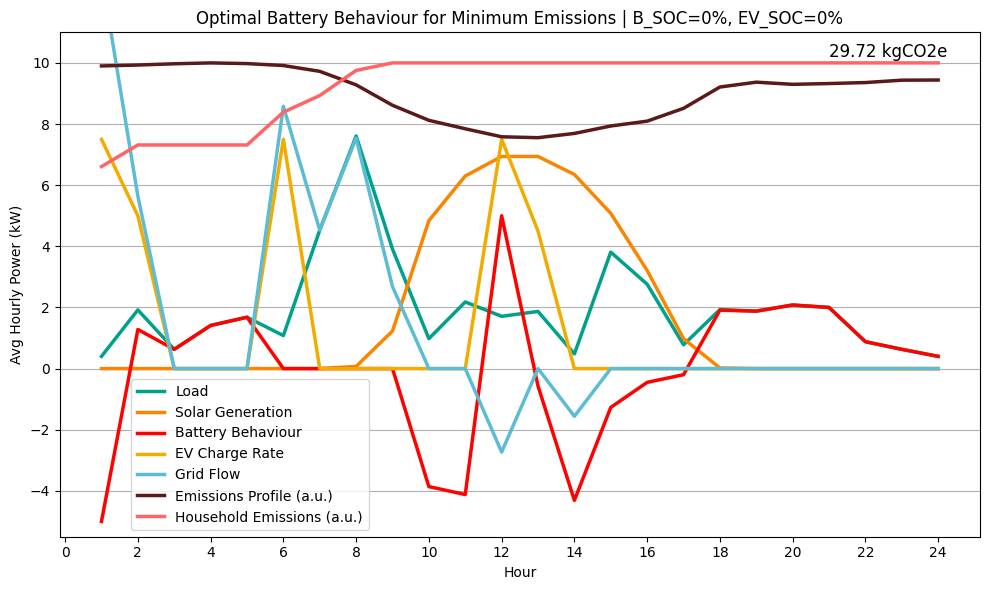

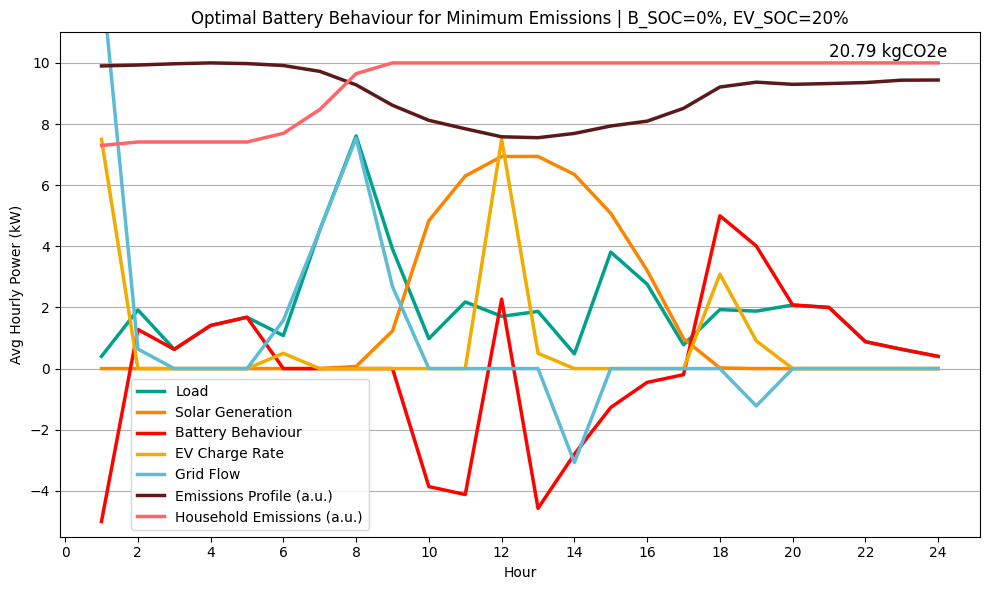

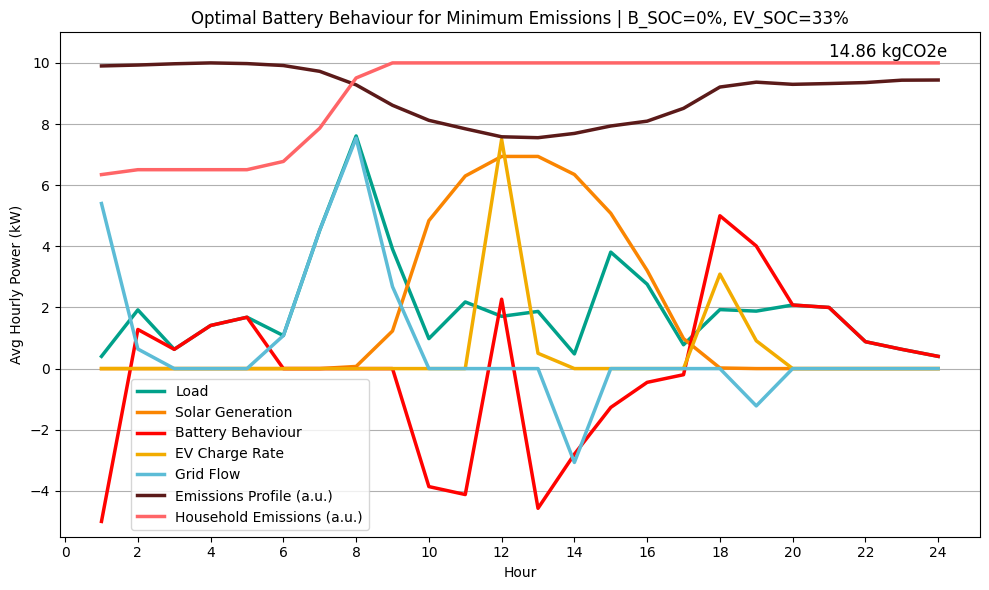

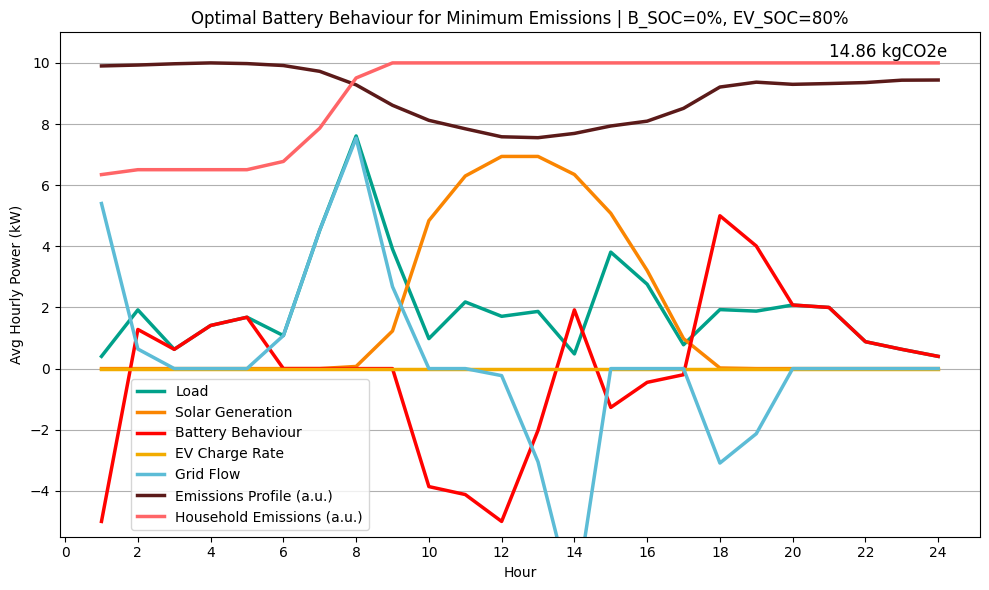

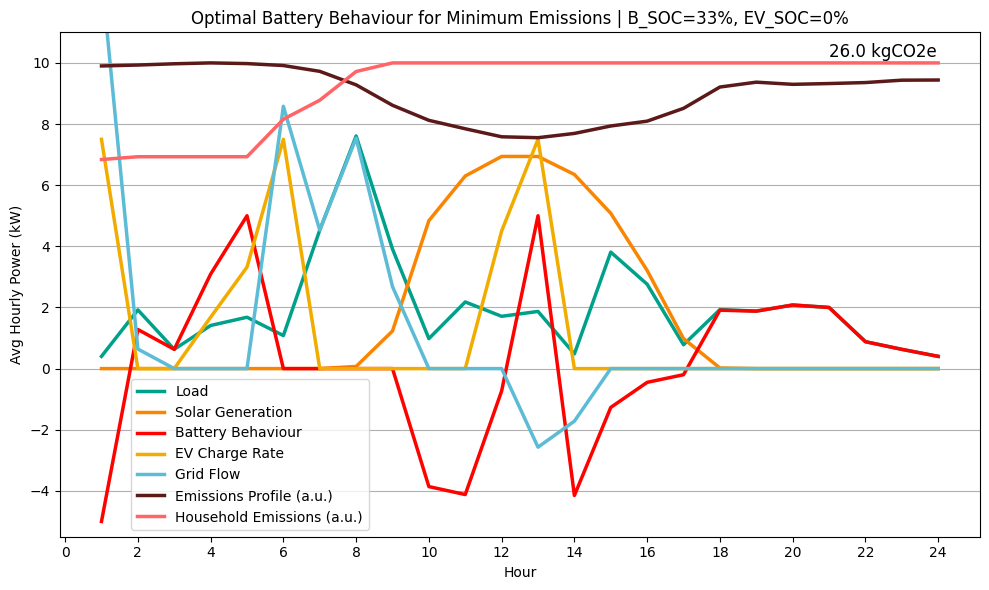

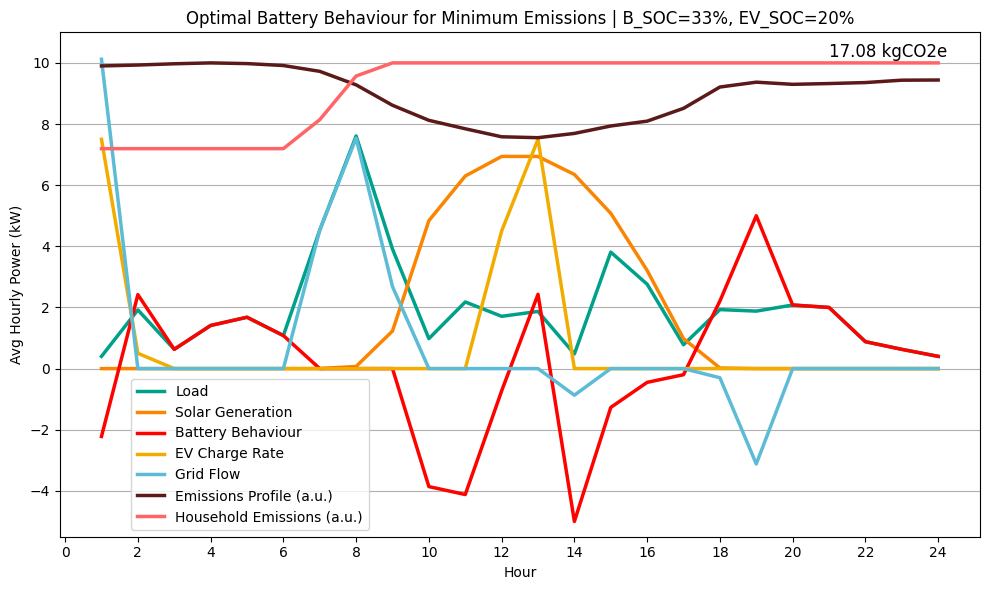

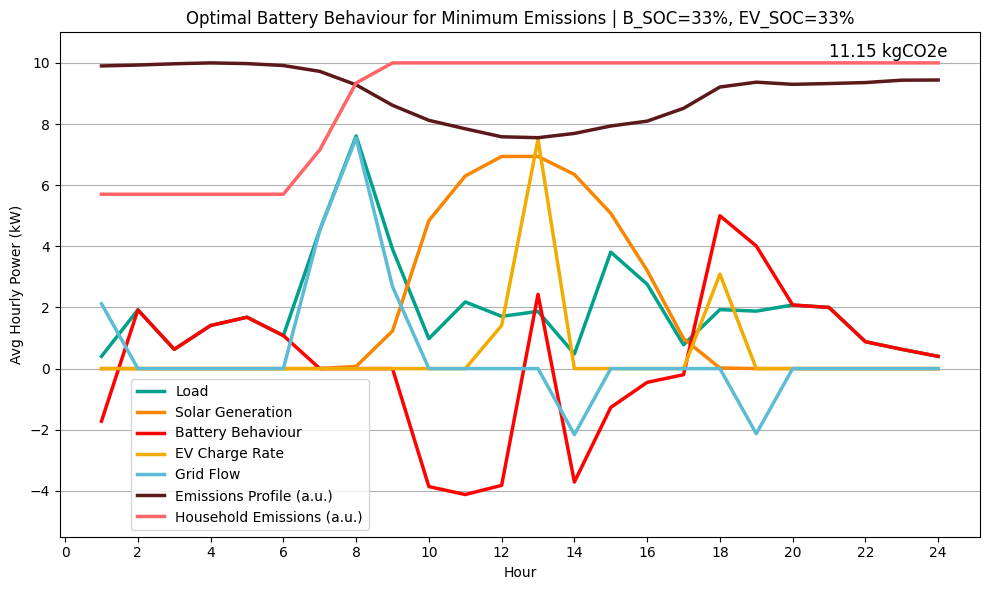

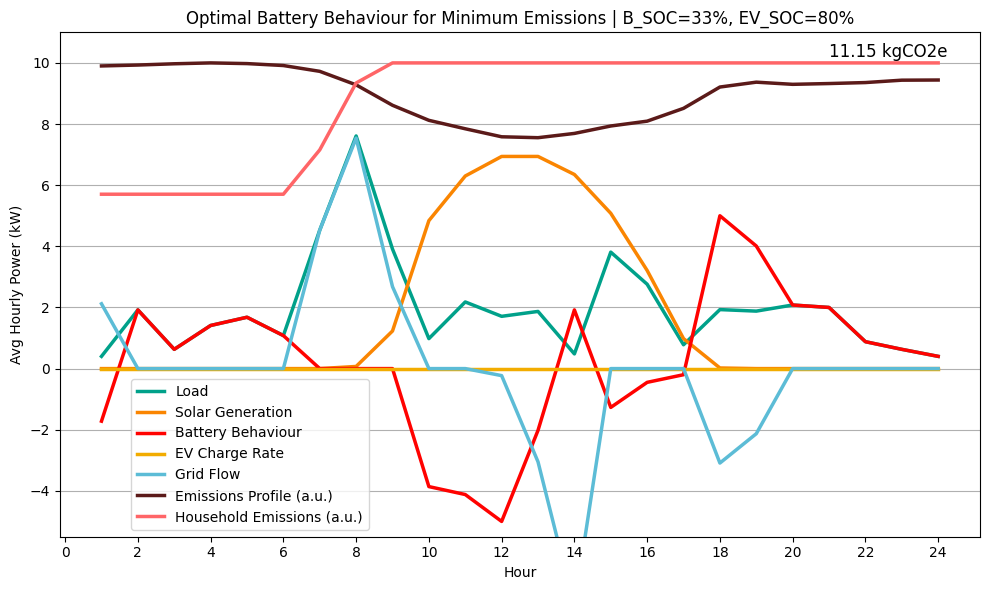

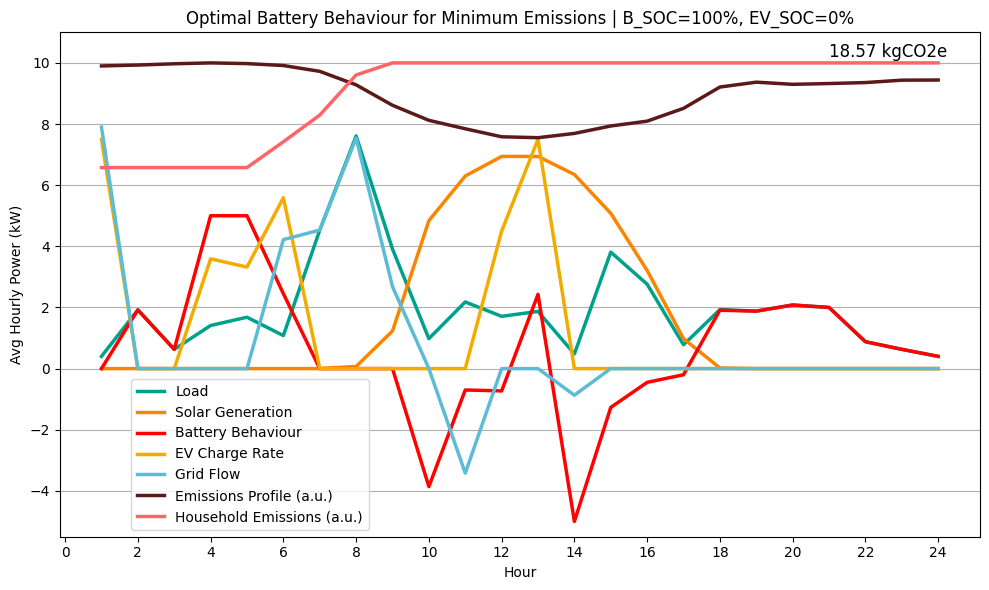

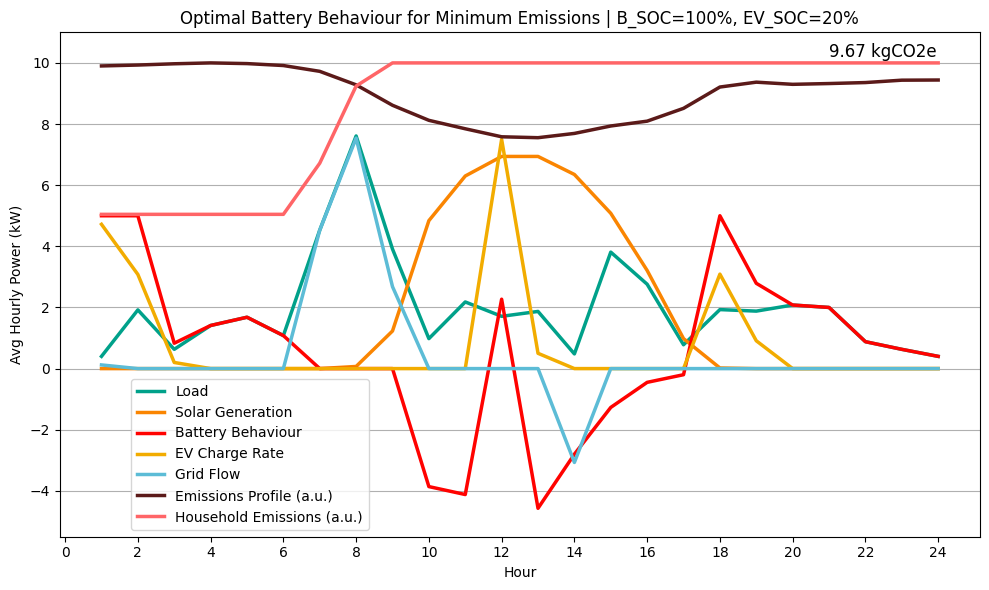

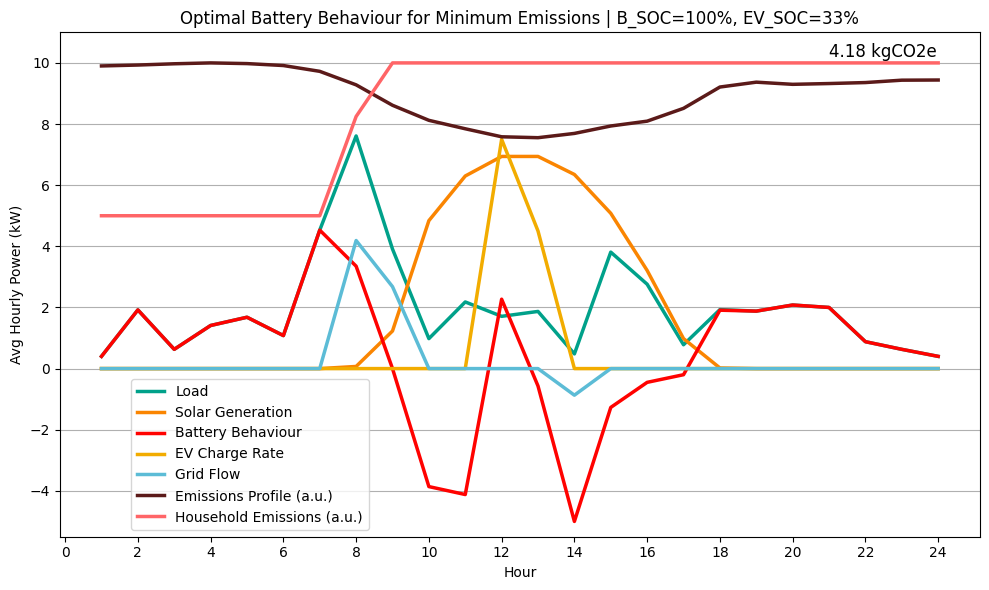

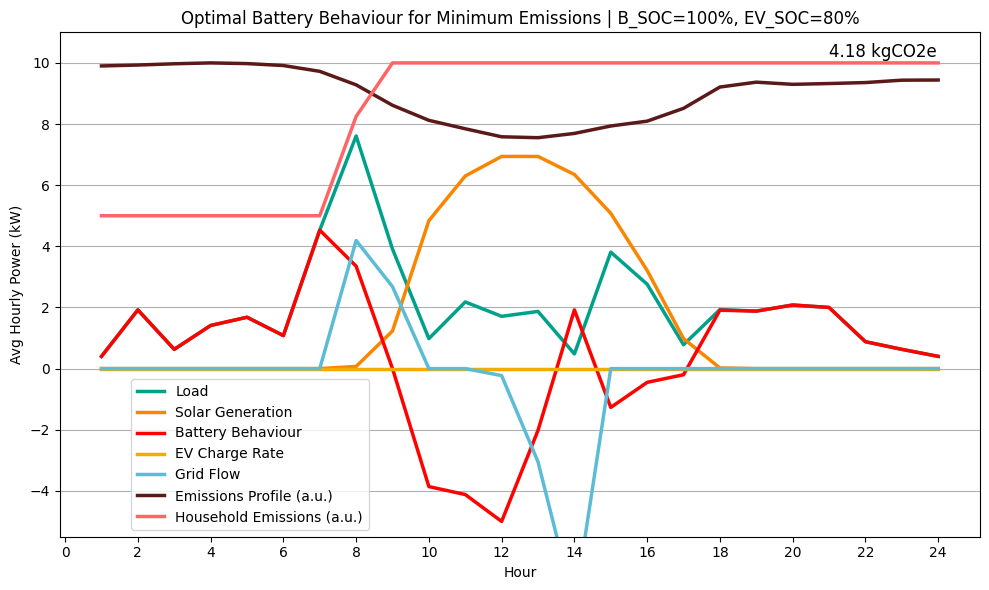

In [128]:
n = df["Cost of energy Import ($/kWh)"].to_list()
m = df["Value of energy export ($/kWh)"].to_list()
l = df["Load (kW)"].to_list()
s = df["Solar Generation (kW)"].to_list()
p = df["Car plugged p(t)"].to_list()
u = df["Car consumption (kWh)"].to_list()
e = df["Emissions (gCO2e/kWh)"].to_list()


def min_emission_battery_flow_day(n, m, l, s, p, u, e, B_SOC=0, EV_SOC=0, B_C=0, EV_C=0):
    """
    Finds the optimal charge and discharge behaviour of a 
    residential battery which minimises the cost for the consumer.

    The following variables are defined for every interval t:

    n: import price ($/kWh)
    m: export price ($/kWh)
    l: load (kW)
    s: solar export (kW)
    p: binary variable - is the EV connected (1) or disconnected (0)
    u: how much energy the EV uses (kWh)
    e: carbon intensity of the grid (gCO2e/kWh)

    where the interval lasts from t=0h to t=24h
    """

    lp = pulp.LpProblem()

    ## variables

    # physical variables
    battery_charge = [Var(f"B_{t}",lowBound=0,upBound=15) for t in range(len(n))]
    ev_charge = [Var(f"EV_{t}",lowBound=0,upBound=60) for t in range(len(n))]

    # decision variables
    b = [Var(f"b_{t}",lowBound=-5,upBound=5) for t in range(len(n))] # discharging is positive
    c = [Var(f"c_{t}",lowBound=0,upBound=7.5) for t in range(len(n))] # charging is positive
    g_i = [Var(f"g_i_{t}",lowBound=0) for t in range(len(n))] # import from grid at t
    g_e = [Var(f"g_e_{t}",lowBound=0) for t in range(len(n))] # export from grid at t

    ## constraints

    # start of the day charge values (midnight)
    lp += battery_charge[0] == B_C
    lp += ev_charge[0] == EV_C

    # flow preservation
    for t in range(len(n)):

        # flow at the meter 
        lp += g_i[t] - g_e[t] + s[t] + b[t] == l[t] + p[t]*c[t]

        # state of battery charge at t+1 timestep is the charge at t
        # summed with the power flowing to or from the battery at t
        if t<len(n)-1:
            lp += battery_charge[t] - b[t] == battery_charge[t+1]
            lp += ev_charge[t] + p[t]*c[t] - u[t] == ev_charge[t+1]
        
        if EV_C == 0:
            if t>= 5:
                lp+=ev_charge[t] >= 12
        else:
            lp+=ev_charge[t] >= 12
            

    # end of the day charge values (midnight)
    lp += ev_charge[-1]+c[-1] >= 12
    lp += battery_charge[-1]-b[-1] >= 0

    ## objective - minimise household emissions
    lp += lpSum(g_i[t]*e[t] for t in range(len(n)))

    lp.solve()

    print(f'Status: {pulp.LpStatus[lp.status]}')
    print(f'Objective: {lp.objective.value()}')
    print('Optimal values:')
    print("B: ",[B_t.value() for B_t in battery_charge])
    print("EV: ",[EV_t.value() for EV_t in ev_charge])
    print("Battery Charge/Discharge rate: ",[b_t.value() for b_t in b])
    print("EV Charge Rate: ",[c_t.value() for c_t in c])
    print("Grid Import Flow: ",[g_t.value() for g_t in g_i])
    import_price = sum([g_t.value()*n[t] for t,g_t in enumerate(g_i)])
    export_price = sum([g_t.value()*m[t] for t,g_t in enumerate(g_e)])
    print("Grid Import Price: ",import_price)
    print("Grid Export Price: ",export_price)
    print("Grid Export Flow: ",[g_t.value() for g_t in g_e])
    print("Grid NET Price: ",import_price-export_price)
    print("NET Grid Flow: ",[i.value() - ex.value() for i,ex in zip(g_i,g_e)])

    e_total=[]
    e_count=0
    for tstep, g_t in enumerate(g_i):
        e_count+=e[tstep]*g_t.value()
        e_total.append(e_count)

    print("Cumulative Emissions: ",e_total)
    
    t = df["Hour"].to_list()

    plt.rcParams['lines.linewidth'] = 2.5
    plt.figure(figsize=(10,6))
    plt.grid(axis='y')

    plt.plot(t,l,label="Load",color=colors[1])
    plt.plot(t,s,label="Solar Generation",color=colors[3])
    plt.plot(t,[b_t.value() for b_t in b],label="Battery Behaviour",color=colors[0])
    plt.plot(t,[c_t.value() if c_t else 0 for c_t in c],label="EV Charge Rate",color=colors[2])
    plt.plot(t,[i.value() - ex.value() for i,ex in zip(g_i,g_e)],label="Grid Flow",color=colors[4])
    plt.plot(t,[e_i/max(e)*5+5 for e_i in e],label="Emissions Profile (a.u.)",color=colors[5])
    plt.plot(t,[e_i/max(e_total)*5+5 for e_i in e_total],label="Household Emissions (a.u.)",color=colors[6])

    plt.annotate(f"{round(e_total[-1]/1000,2)} kgCO2e",(21,10.2),fontsize=12)
    plt.ylim([-5.5,11])

    plt.title(f"Optimal Battery Behaviour for Minimum Emissions | B_SOC={B_SOC}%, EV_SOC={EV_SOC}%")
    plt.ylabel("Avg Hourly Power (kW)")
    plt.xlabel("Hour")
    plt.legend(bbox_to_anchor=[0.07, 0],loc="lower left")
    # plt.show()
    plt.xticks(ticks=[i for i in range(0,25,2)],labels=["0","2","4","6","8","10","12","14","16","18","20","22","24"])
    plt.tight_layout()
    plt.savefig(f"MinEmission/emissions_optimal_b{B_C}_ev{EV_C}.png",dpi=200)

    return round(import_price-export_price,2)

cost_data = {0:[],
             5:[],
             15:[]}

for bc, bsoc in [(0,0),(5,33),(15,100)]:
    for evc,evsoc in [(0,0),(12,20),(20,33),(48,80)]:

        cost_data[bc].append(min_emission_battery_flow_day(n,m,l,s,p,u,e,B_C=bc,B_SOC=bsoc,EV_C=evc,EV_SOC=evsoc))

print(cost_data)
# min_emission_battery_flow_day(n,m,l,s,p,u,e)


In [129]:
cost_data

{0: [10.98, 8.58, 6.98, 6.02],
 5: [9.98, 7.58, 5.98, 5.02],
 15: [7.98, 5.68, 2.68, 1.86]}

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/42/f9_c0v657j907h_6gh8ly4mw0000gn/T/23482be7134844bfba78e02b0150ccd1-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/42/f9_c0v657j907h_6gh8ly4mw0000gn/T/23482be7134844bfba78e02b0150ccd1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 80 COLUMNS
At line 349 RHS
At line 425 BOUNDS
At line 535 ENDATA
Problem MODEL has 75 rows, 133 columns and 220 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 50 (-25) rows, 107 (-26) columns and 168 (-52) elements
Perturbing problem by 0.001% of 756.105 - largest nonzero change 8.0187714e-05 ( 1.2181841e-05%) - largest zero change 7.8115771e-05
0  Obj 7765.4112 Primal inf 235.90995 (48) Dual inf 14530.574 (24)
0  Obj 7765.4096 P

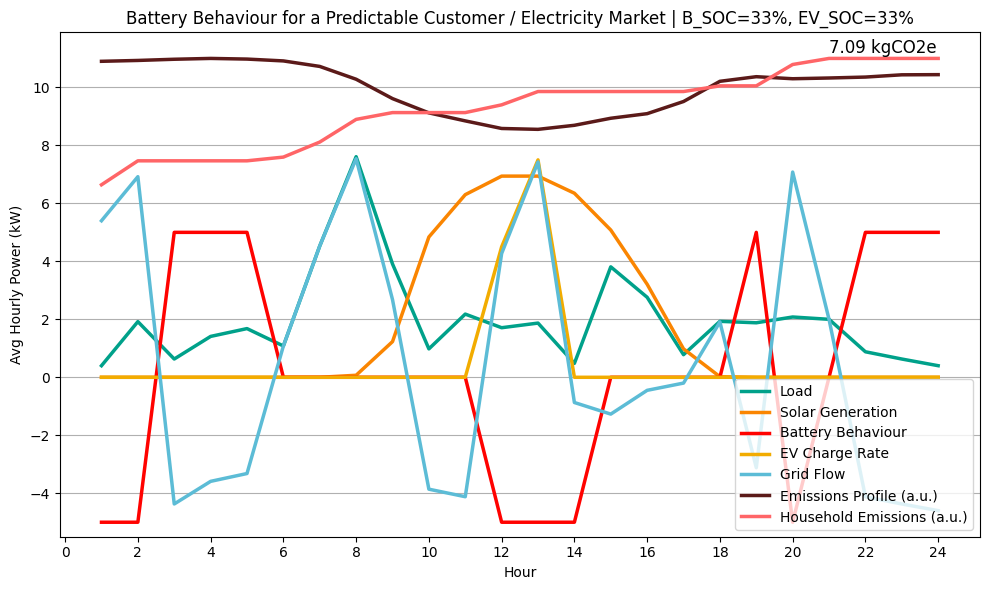

In [78]:
# with offset

n = df["Cost of energy Import ($/kWh)"].to_list()
m = df["Value of energy export ($/kWh)"].to_list()
l = df["Load (kW)"].to_list()
s = df["Solar Generation (kW)"].to_list()
p = df["Car plugged p(t)"].to_list()
u = df["Car consumption (kWh)"].to_list()
e = df["Emissions (gCO2e/kWh)"].to_list()


def min_emission_battery_flow_day(n, m, l, s, p, u, e):
    """
    Finds the optimal charge and discharge behaviour of a 
    residential battery which minimises the cost for the consumer.

    The following variables are defined for every interval t:

    n: import price ($/kWh)
    m: export price ($/kWh)
    l: load (kW)
    s: solar export (kW)
    p: binary variable - is the EV connected (1) or disconnected (0)
    u: how much energy the EV uses (kWh)
    e: carbon intensity of the grid (gCO2e/kWh)

    where the interval lasts from t=0h to t=24h
    """

    lp = pulp.LpProblem()

    ## variables

    # physical variables
    battery_charge = [Var(f"B_{t}",lowBound=0,upBound=15) for t in range(len(n))]
    ev_charge = [Var(f"EV_{t}",lowBound=0,upBound=60) for t in range(len(n))]

    # decision variables
    b = [Var(f"b_{t}",lowBound=-5,upBound=5) for t in range(len(n))] # discharging is positive
    c = [Var(f"c_{t}",lowBound=0,upBound=7.5) for t in range(len(n))] # charging is positive
    g_i = [Var(f"g_i_{t}",lowBound=0) for t in range(len(n))] # import from grid at t
    g_e = [Var(f"g_e_{t}",lowBound=0) for t in range(len(n))] # export from grid at t

    ## constraints

    # start of the day charge values (midnight)
    lp += battery_charge[0] == 5
    lp += ev_charge[0] == 20

    # flow preservation
    for t in range(len(n)):

        # flow at the meter 
        lp += g_i[t] - g_e[t] + s[t] + b[t] == l[t] + p[t]*c[t]

        # state of battery charge at t+1 timestep is the charge at t
        # summed with the power flowing to or from the battery at t
        if t<len(n)-1:
            lp += battery_charge[t] - b[t] == battery_charge[t+1]
            lp += ev_charge[t] + p[t]*c[t] - u[t] == ev_charge[t+1]

    # end of the day charge values (midnight)
    lp += ev_charge[-1]+c[-1] >= 12
    lp += battery_charge[-1]-b[-1] >= 0

    # ev should have enough charge at the start of the day 
    # impose rule that ev is charged to 20% SOC at the start of 7 am
    lp += ev_charge[5]+c[5] >= 12

    ## objective - minimise household emissions
    lp += lpSum(g_i[t]*e[t] - g_e[t]*e[t] for t in range(len(n)))

    lp.solve()

    print(f'Status: {pulp.LpStatus[lp.status]}')
    print(f'Objective: {lp.objective.value()}')
    print('Optimal values:')
    print("B: ",[B_t.value() for B_t in battery_charge])
    print("EV: ",[EV_t.value() for EV_t in ev_charge])
    print("Battery Charge/Discharge rate: ",[b_t.value() for b_t in b])
    print("EV Charge Rate: ",[c_t.value() for c_t in c])
    print("Grid Import Flow: ",[g_t.value() for g_t in g_i])
    import_price = sum([g_t.value()*n[t] for t,g_t in enumerate(g_i)])
    export_price = sum([g_t.value()*m[t] for t,g_t in enumerate(g_e)])
    print("Grid Import Price: ",import_price)
    print("Grid Export Price: ",export_price)
    print("Grid Export Flow: ",[g_t.value() for g_t in g_e])
    print("Grid NET Price: ",import_price-export_price)
    print("NET Grid Flow: ",[i.value() - ex.value() for i,ex in zip(g_i,g_e)])

    e_total=[]
    e_count=0
    for tstep, g_t in enumerate(g_i):
        e_count+=e[tstep]*g_t.value()
        e_total.append(e_count)

    print("Cumulative Emissions: ",e_total)
    
    t = df["Hour"].to_list()

    plt.rcParams['lines.linewidth'] = 2.5
    plt.figure(figsize=(10,6))
    plt.grid(axis='y')

    plt.plot(t,l,label="Load",color=colors[1])
    plt.plot(t,s,label="Solar Generation",color=colors[3])
    plt.plot(t,[b_t.value() for b_t in b],label="Battery Behaviour",color=colors[0])
    plt.plot(t,[c_t.value() if c_t else 0 for c_t in c],label="EV Charge Rate",color=colors[2])
    plt.plot(t,[i.value() - ex.value() for i,ex in zip(g_i,g_e)],label="Grid Flow",color=colors[4])
    plt.plot(t,[e_i/max(e)*5+6 for e_i in e],label="Emissions Profile (a.u.)",color=colors[5])
    plt.plot(t,[e_i/max(e_total)*5+6 for e_i in e_total],label="Household Emissions (a.u.)",color=colors[6])

    plt.annotate(f"{round(lp.objective.value()/1000,2)} kgCO2e",(21,11.2),fontsize=12)
    plt.ylim([-5.5,11.9])

    plt.title(r"Battery Behaviour for a Predictable Customer / Electricity Market | B_SOC=33%, EV_SOC=33%")
    plt.ylabel("Avg Hourly Power (kW)")
    plt.xlabel("Hour")
    plt.legend(loc="lower right")
    # plt.show()
    plt.xticks(ticks=[i for i in range(0,25,2)],labels=["0","2","4","6","8","10","12","14","16","18","20","22","24"])
    plt.tight_layout()
    plt.savefig("emissions_optimal_b5_ev20_w_offset.png",dpi=200)

min_emission_battery_flow_day(n,m,l,s,p,u,e)
